In [271]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import emoji
%matplotlib inline 

#importing rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from utility import FeatureGenerator
from rdkit.Chem import PandasTools as PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects

#importing sklearn 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

**1. Scientific/Business Understanding**

Being a scientist and eager to learn new method in my researech field, exploring chemoinformatics approach in drug discovery is quite interesting. For this project I am using the experimental *log P* data released in the paper: “Large, chemically diverse dataset of *log P* measurements for benchmarking studies” by Martel et al: https://doi.org/10.1016/j.ejps.2012.10.019. As this is a preliminary study, we are interested in finding which featurization methods work best for predicting *log P*. The octanol-water partition coefficient (*log P*), is one of the most important properties for determining a compound’s suitability as a drug. This coefficient strongly affects how easily the drug can reach its intended target in the body, how strong an effect it will have once it reaches its target, and how long it will remain in the body in an active form, hence used in decision-making by medicinal chemists in pre-clinical drug discovery. The raw data is downloaded from https://ochem.eu/article/27772.

I will focus on the three question below:

Q1: What are are options for *log P* prediction are based on physical descriptors, such as atom type counts, or polar surface area, or on topological descriptors?

Q2: What's the *log P* distribution like? How is it related to drug likeliness?

Q3: How is molecular descriptor have effect on *log P*? Can we predict *log P* based on molecular descriptor set?

**2. Data understanding**

In [272]:
#load data
df = pd.read_csv("data.csv")
df.head()

,SMILES,CASRN,MOLECULEID,EXTERNALID,N,NAME,NAME.1,ARTICLEID,PUBMEDID,PAGE,TABLE,logPow {measured},UNIT {logPow},"logPow {measured, converted}",UNIT {logPow}.1,pH,UNIT {pH}
0,COC1=CC=CC=C1[C@@H]1CC(=O)NC2=C1C=C(C)C(C)=C2,-,M1018998,ZINC00036522,1,-,-,A27772,23131797,-,2,4.17,Log unit,4.17,Log unit,5.0,Log unit
1,COC1=CC=C2C(=O)C[C@](O)(OC2=C1)C(F)(F)F,-,M1019732,ZINC00185379,3,-,-,A27772,23131797,-,2,2.79,Log unit,2.79,Log unit,5.0,Log unit
2,CC(C)(C)C1(C)O[C@@H]([C@@H](O1)C(N)=O)C(N)=O,-,M3410220,ZINC12402487,4,-,-,A27772,23131797,-,2,1.60,Log unit,1.60,Log unit,= 6.5,Log unit
3,CCOC1=CC(=CC(OCC)=C1OCC)C1=NN=C(O1)C1=CC=CO1,-,M1019125,ZINC00055459,5,-,-,A27772,23131797,-,2,3.96,Log unit,3.96,Log unit,= 10.5,Log unit
4,CN(C)C1=CC=C(C=C1)C(=C)C1=CC=C(C=C1)N(C)C,-,M78769,ZINC00056871,6,-,-,A27772,23131797,-,2,5.30,Log unit,5.30,Log unit,= 7.3,Log unit


In [273]:
#number of rows and column
print(f'No. of rows {df.shape[0]}, no of columns {df.shape[1]}')

No. of rows 707, no of columns 17


In [274]:
#summary statistics
df.describe()   

,N,PUBMEDID,TABLE,logPow {measured},"logPow {measured, converted}"
count,707.000000,707.0,707.0,707.000000,707.000000
mean,491.585573,23131797.0,2.0,4.188713,4.188713
std,291.618041,0.0,0.0,1.179046,1.179046
min,1.000000,23131797.0,2.0,0.300000,0.300000
25%,239.500000,23131797.0,2.0,3.460000,3.460000
50%,511.000000,23131797.0,2.0,4.330000,4.330000
75%,750.500000,23131797.0,2.0,4.980000,4.980000
max,995.000000,23131797.0,2.0,6.960000,6.960000


In [275]:
#missing values
df.isnull().sum(axis=0)

SMILES                          0
CASRN                           0
MOLECULEID                      0
EXTERNALID                      0
N                               0
NAME                            0
NAME.1                          0
ARTICLEID                       0
PUBMEDID                        0
PAGE                            0
TABLE                           0
logPow {measured}               0
UNIT {logPow}                   0
logPow {measured, converted}    0
UNIT {logPow}.1                 0
pH                              0
UNIT {pH}                       0
dtype: int64

In [276]:

# data format for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 17 columns):
SMILES                          707 non-null object
CASRN                           707 non-null object
MOLECULEID                      707 non-null object
EXTERNALID                      707 non-null object
N                               707 non-null int64
NAME                            707 non-null object
NAME.1                          707 non-null object
ARTICLEID                       707 non-null object
PUBMEDID                        707 non-null int64
PAGE                            707 non-null object
TABLE                           707 non-null int64
logPow {measured}               707 non-null float64
UNIT {logPow}                   707 non-null object
logPow {measured, converted}    707 non-null float64
UNIT {logPow}.1                 707 non-null object
pH                              707 non-null object
UNIT {pH}                       707 non-null object
dtypes: floa

In [277]:
df.columns

Index(['SMILES', 'CASRN', 'MOLECULEID', 'EXTERNALID', 'N', 'NAME', 'NAME.1',
       'ARTICLEID', 'PUBMEDID', 'PAGE', 'TABLE', 'logPow {measured}',
       'UNIT {logPow}', 'logPow {measured, converted}', 'UNIT {logPow}.1',
       'pH', 'UNIT {pH}'],
      dtype='object')

**3. Prepare Data**

There are some necessary stpes to apply before continue exploring the dataset:

Drop unused columns

Convert string values to number


In [278]:
from copy import deepcopy
data = df.copy(deep=True)

In [279]:
# Drop unused columns
columns_to_drop = ['CASRN', 'MOLECULEID','ARTICLEID', 'PUBMEDID', 'PAGE', 'TABLE', 'UNIT {logPow}', 
                   'logPow {measured, converted}', 'UNIT {logPow}.1','UNIT {pH}', 'NAME', 'NAME.1']

data.drop(columns_to_drop, axis=1, inplace=True)

#renaming logP column
data.rename(columns={'logPow {measured}': 'logPexp', 'EXTERNALID': 'ZINC_ID'}, inplace=True)

In [280]:
#rearraging columns sequence
data = data[['N', 'ZINC_ID', 'SMILES', 'logPexp', 'pH']]

In [281]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 5 columns):
N          707 non-null int64
ZINC_ID    707 non-null object
SMILES     707 non-null object
logPexp    707 non-null float64
pH         707 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 27.7+ KB


In [282]:
data.head()

,N,ZINC_ID,SMILES,logPexp,pH
0,1,ZINC00036522,COC1=CC=CC=C1[C@@H]1CC(=O)NC2=C1C=C(C)C(C)=C2,4.17,5.0
1,3,ZINC00185379,COC1=CC=C2C(=O)C[C@](O)(OC2=C1)C(F)(F)F,2.79,5.0
2,4,ZINC12402487,CC(C)(C)C1(C)O[C@@H]([C@@H](O1)C(N)=O)C(N)=O,1.60,= 6.5
3,5,ZINC00055459,CCOC1=CC(=CC(OCC)=C1OCC)C1=NN=C(O1)C1=CC=CO1,3.96,= 10.5
4,6,ZINC00056871,CN(C)C1=CC=C(C=C1)C(=C)C1=CC=C(C=C1)N(C)C,5.30,= 7.3


In [283]:
#cleaning pH column as some of the values has '=' 
data['pH'] = pd.to_numeric(data['pH'].map(lambda x: x.lstrip('=').rstrip('=')))

In [284]:
data.head()


,N,ZINC_ID,SMILES,logPexp,pH
0,1,ZINC00036522,COC1=CC=CC=C1[C@@H]1CC(=O)NC2=C1C=C(C)C(C)=C2,4.17,5.0
1,3,ZINC00185379,COC1=CC=C2C(=O)C[C@](O)(OC2=C1)C(F)(F)F,2.79,5.0
2,4,ZINC12402487,CC(C)(C)C1(C)O[C@@H]([C@@H](O1)C(N)=O)C(N)=O,1.60,6.5
3,5,ZINC00055459,CCOC1=CC(=CC(OCC)=C1OCC)C1=NN=C(O1)C1=CC=CO1,3.96,10.5
4,6,ZINC00056871,CN(C)C1=CC=C(C=C1)C(=C)C1=CC=C(C=C1)N(C)C,5.30,7.3


In [285]:
data.describe()

,N,logPexp,pH
count,707.000000,707.000000,707.000000
mean,491.585573,4.188713,6.438614
std,291.618041,1.179046,2.292337
min,1.000000,0.300000,2.000000
25%,239.500000,3.460000,5.000000
50%,511.000000,4.330000,5.000000
75%,750.500000,4.980000,7.300000
max,995.000000,6.960000,10.500000


#### *log P* distribution plot

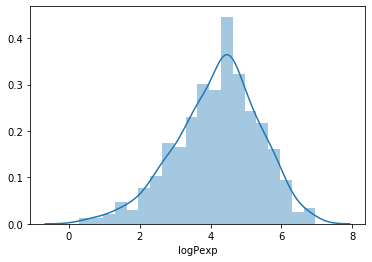

In [286]:
sns.distplot(data['logPexp'])

#### pH distribution plot

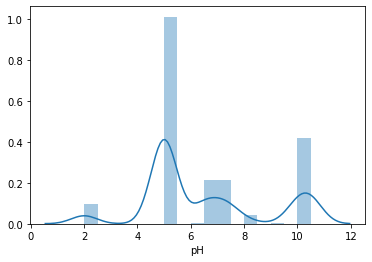

In [287]:
sns.distplot(data['pH'])

We can see that there is no missing values. We drop few unnecessary columns and cleaned the pH column values and converted into interger values

**4. Answer Questions base on dataset**

Q1: Visualize molecules and check how simillar they are?

In [288]:
#Convert SMILES to 2D molecules:
molecules = data.SMILES.apply(Chem.MolFromSmiles)

Visualizing 20 molecules in 5*4 grid

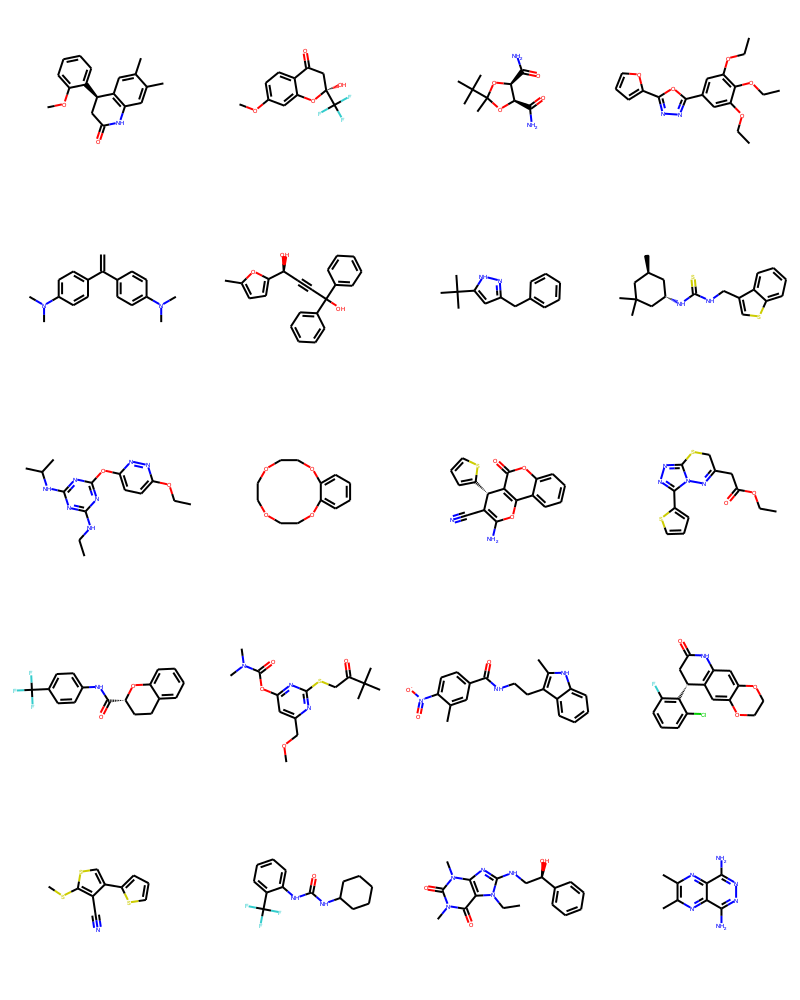

In [289]:
#Display some of the moecules
Draw.MolsToGridImage(molecules[:20],molsPerRow=4)

Tanimoto Similarity Coefficient of molecule_1 vs molecule_1: 1.0
Tanimoto Similarity Coefficient of molecule_1 vs molecule_2: 0.1875


Text(0.5, 1.0, 'Pairwise similarity all molecules')

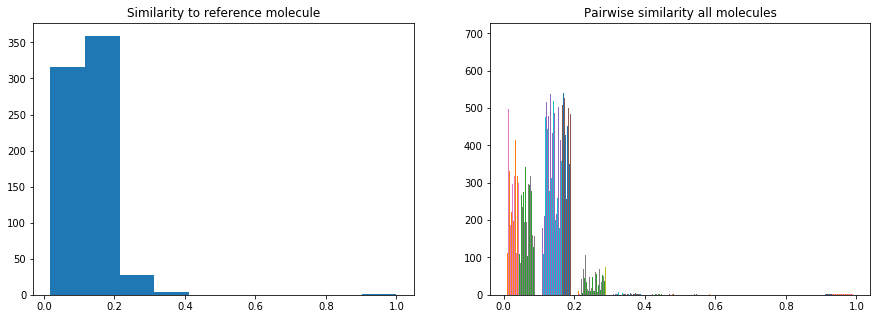

In [290]:
## Similarity Calculations

# We calculate Morgan fingerprints 
mols_fps=[AllChem.GetMorganFingerprintAsBitVect(x,2) for x in molecules]
print(f'Tanimoto Similarity Coefficient of molecule_1 vs molecule_1: {DataStructs.TanimotoSimilarity(mols_fps[0],mols_fps[0])}')
print(f'Tanimoto Similarity Coefficient of molecule_1 vs molecule_2: {DataStructs.TanimotoSimilarity(mols_fps[0],mols_fps[1])}')

# Calculate similarities to reference molecule
sim_ref = DataStructs.BulkTanimotoSimilarity(mols_fps[0],mols_fps)


# Calculate pairwise similarities
def pairwise_sim(mols):
    pairwise=[]
    for i in mols:
        sim = DataStructs.BulkTanimotoSimilarity(i,mols)
        pairwise.append(sim)
    return pairwise

PW = pairwise_sim(mols_fps)
figure,(plt1,plt2) = plt.subplots(1,2)
figure.set_size_inches(15,5)
plt1.hist(sim_ref)
plt1.set_title('Similarity to reference molecule')
plt2.hist(PW)
plt2.set_title('Pairwise similarity all molecules')

We have generated a connectivity fingerprint using Morgan Fingerprint and based on this fingerprint calculated the similarity measure. From the result and plot from sililarity and pairwise similarity it seems that most of the molecules are quite different from the reference molecule (molecule_0). This is a good indication for having diverse set of molecule covering large chemical space. 

**3. Prepare Data (feature engineering)**

Next, we use RDKit to calculate some of molecular descriptors 

In [291]:
data.loc[:, 'MolLogP'] = molecules.apply(Descriptors.MolLogP)
data.loc[:, 'HeavyAtomCount'] = molecules.apply(Descriptors.HeavyAtomCount)
data.loc[:, 'HAccept'] = molecules.apply(Descriptors.NumHAcceptors)
data.loc[:, 'Heteroatoms'] = molecules.apply(Descriptors.NumHeteroatoms)
data.loc[:, 'HDonor'] = molecules.apply(Descriptors.NumHDonors)
data.loc[:, 'MolWt'] = molecules.apply(Descriptors.MolWt)
data.loc[:, 'RotableBonds'] = molecules.apply(Descriptors.NumRotatableBonds)
data.loc[:, 'RingCount'] = molecules.apply(Descriptors.RingCount)
data.loc[:, 'Ipc'] = molecules.apply(Descriptors.Ipc)
data.loc[:, 'HallKierAlpha'] = molecules.apply(Descriptors.HallKierAlpha)
data.loc[:, 'NumValenceElectrons'] = molecules.apply(Descriptors.NumValenceElectrons)
data.loc[:, 'SaturatedRings'] = molecules.apply(Descriptors.NumSaturatedRings)
data.loc[:, 'AliphaticRings'] = molecules.apply(Descriptors.NumAliphaticRings)
data.loc[:, 'AromaticRings'] = molecules.apply(Descriptors.NumAromaticRings)

In [292]:
data.head()

,N,ZINC_ID,SMILES,logPexp,pH,MolLogP,HeavyAtomCount,HAccept,Heteroatoms,HDonor,MolWt,RotableBonds,RingCount,Ipc,HallKierAlpha,NumValenceElectrons,SaturatedRings,AliphaticRings,AromaticRings
0,1,ZINC00036522,COC1=CC=CC=C1[C@@H]1CC(=O)NC2=C1C=C(C)C(C)=C2,4.17,5.0,3.78614,21,2,3,1,281.355,2,3,69759.740168,-2.29,108,0,1,2
1,3,ZINC00185379,COC1=CC=C2C(=O)C[C@](O)(OC2=C1)C(F)(F)F,2.79,5.0,1.91130,18,4,7,1,262.183,1,2,7977.096898,-1.76,98,0,1,1
2,4,ZINC12402487,CC(C)(C)C1(C)O[C@@H]([C@@H](O1)C(N)=O)C(N)=O,1.60,6.5,-0.49670,16,4,6,2,230.264,2,1,2165.098769,-1.14,92,1,1,0
3,5,ZINC00055459,CCOC1=CC(=CC(OCC)=C1OCC)C1=NN=C(O1)C1=CC=CO1,3.96,10.5,4.19270,25,7,7,0,344.367,8,3,819166.201010,-2.96,132,0,0,3
4,6,ZINC00056871,CN(C)C1=CC=C(C=C1)C(=C)C1=CC=C(C=C1)N(C)C,5.30,7.3,3.88010,20,2,2,0,266.388,4,2,32168.378171,-2.22,104,0,0,2


As a baseline, we calculate the performance of RDKit’s calculated MolLogP vs the experimental log P.

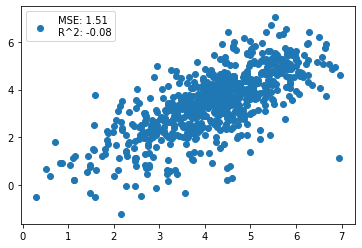

In [293]:
r2 = r2_score(data.logPexp, data.MolLogP)
mse = mean_squared_error(data.logPexp, data.MolLogP)
plt.scatter(data.logPexp, data.MolLogP,
            label = "MSE: {:.2f}\nR^2: {:.2f}".format(mse, r2))
plt.legend()
plt.show()

As we can see above, RDKit’s *log P* predictions have a relatively high mean square error, and a weak $R^2$ of determination for this dataset. RDKit’s MolLogP implementation is based on atomic contributions. Hence, we will first try to train our own simple *log P* model using the RDKit physical descriptors that we generated above.

# Simple descriptor models traning

Following descriptor we will use to train our simple model

In [294]:
X = data.iloc[:, 6:]
y = data.logPexp
X.head()

,HeavyAtomCount,HAccept,Heteroatoms,HDonor,MolWt,RotableBonds,RingCount,Ipc,HallKierAlpha,NumValenceElectrons,SaturatedRings,AliphaticRings,AromaticRings
0,21,2,3,1,281.355,2,3,69759.740168,-2.29,108,0,1,2
1,18,4,7,1,262.183,1,2,7977.096898,-1.76,98,0,1,1
2,16,4,6,2,230.264,2,1,2165.098769,-1.14,92,1,1,0
3,25,7,7,0,344.367,8,3,819166.201010,-2.96,132,0,0,3
4,20,2,2,0,266.388,4,2,32168.378171,-2.22,104,0,0,2


For the regression, we will use a Random Forest with the default parameters from scikit-learn, and set aside one 20\% of the data for testing.

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Default models
models = {"rf": RandomForestRegressor(n_estimators=100, random_state=42)}

scores = {}
for m in models:
    models[m].fit(X_train, y_train)
    scores[m + "_train"] = models[m].score(X_train, y_train, )
    y_pred = models[m].predict(X_test)
    scores[m + "_test"] = r2_score(y_test, y_pred)
    scores[m + "_mse_test"] = mean_squared_error(y_test, y_pred)

In [296]:
scores = pd.Series(scores).T
scores

rf_train       0.914903
rf_test        0.503457
rf_mse_test    0.682586
dtype: float64

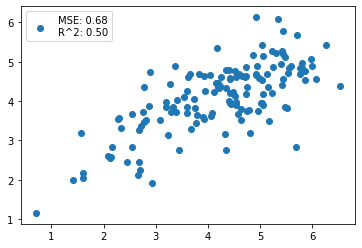

In [297]:
r_2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
plt.scatter(y_test, y_pred, label = "MSE: {:.2f}\nR^2: {:.2f}".format(mse, r_2))
plt.legend()
plt.show()

As we can see, using these simple descriptors coupled with scikit-learn’s default random forest gets us a higher R2 and MSE performance than the RDKit *log P* predictor. It would be interesting to see how much we can improve the performance by tuning the random forest parameters.

In [298]:
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [299]:
estimator = RandomForestRegressor()

In [300]:
grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

In [301]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 

In [302]:
grid.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=700,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [303]:
grid.best_params_

{'max_features': 'auto', 'n_estimators': 700}

In [304]:
models = {"rf": RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)}

scores = {}
for m in models:
    models[m].fit(X_train, y_train)
    scores[m + "_train"] = models[m].score(X_train, y_train, )
    y_pred = models[m].predict(X_test)
    scores[m + "_test"] = r2_score(y_test, y_pred)
    scores[m + "_mse_test"] = mean_squared_error(y_test, y_pred)

In [305]:
scores = pd.Series(scores).T
scores

rf_train       0.919272
rf_test        0.489389
rf_mse_test    0.701924
dtype: float64

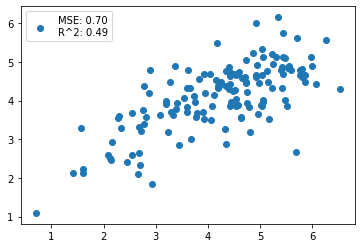

In [306]:
r_2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
plt.scatter(y_test, y_pred, label = "MSE: {:.2f}\nR^2: {:.2f}".format(mse, r_2))
plt.legend()
plt.show()

Hyperparameter tuning which essentially relies more on experimental results than theory, and thus the best method to determine the optimal settings is to try many different combinations evaluate the performance of each model. In our case its seems to improve the estimates a bit but not very significant. 

# Continue Preparing Data for Q3

## Calculating some more advanced moleculating fingerprint ##

We will test Morgan fingerprints (ECFP4 and ECFP6), RDKFingerprints, and topological pharmacophore fingerprints (TPAPF and TPATF), the scripts for which are available from [MayaChemTools](http://www.mayachemtools.org/).

Just note here that I am running this notebook on a super computing [PL-Grid Infrastructure](http://www.plgrid.pl/en) where each computing node has 24 cpu and 128 GB of memory which is quite impressive.To utlize the max cpu utilization lets create a function for parallelizing a DataFrame’s apply() function. This makes TPATF and TPAPF fingerprint calculation much faster. 

In [307]:
import multiprocessing
from joblib import Parallel, delayed

def applyParallel(df, func):
    """This function splits a pandas Series into n chunks,
    corresponding to the number of available CPUs. Then it
    applies a given function to the dataframe chunks, and 
    finally, returns their concatenated output."""
    n_jobs=multiprocessing.cpu_count()
    groups =  np.array_split(df, n_jobs)
    results = Parallel(n_jobs)(delayed(lambda g: g.apply(func))(group) for group in groups)
    return pd.concat(results)

Calculate fingerprints:

In [308]:
fps = {"ECFP4": molecules.apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048)),
       "ECFP6": molecules.apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=3, nBits=2048)),
       "RDKFP": molecules.apply(lambda m: AllChem.RDKFingerprint(m, fpSize=2048)),
       "TPATF": applyParallel(data.SMILES, lambda m: FeatureGenerator(m).toTPATF()),
       "TPAPF": applyParallel(data.SMILES, lambda m: FeatureGenerator(m).toTPAPF())}

In [309]:
fps.keys()

dict_keys(['ECFP4', 'ECFP6', 'RDKFP', 'TPATF', 'TPAPF'])

# 5. Train model and Measure Performance

Finally, here we apply three different types of regression models to estimate the performance of these calculated different fingerprints.

In [310]:
# Default models
models = {"rf": RandomForestRegressor(n_estimators=100, random_state=42),
          "nnet": MLPRegressor(random_state=42),
          "svr": SVR(gamma='auto')}

scores = {}

for f in fps:
    scores[f] = {}
    # Convert fps to 2D numpy array
    X = np.array(fps[f].tolist())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    for m in models:
        models[m].fit(X_train, y_train)
        y_pred = models[m].predict(X_test)
        scores[f][m + "_r2_test"] = r2_score(y_test, y_pred)
        scores[f][m + "_mse_test"] = mean_squared_error(y_test, y_pred)
        

/Users/prashant/sfs0/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/prashant/sfs0/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [313]:
scores_df = pd.DataFrame(scores).T
scores_df

,rf_r2_test,rf_mse_test,nnet_r2_test,nnet_mse_test,svr_r2_test,svr_mse_test
ECFP4,0.156600,1.217715,0.044412,1.379694,0.059731,1.357576
ECFP6,0.193432,1.164537,0.150649,1.226307,0.073025,1.338382
RDKFP,0.271040,1.052484,0.158263,1.215313,0.263249,1.063734
TPATF,0.504879,0.714864,-1.150057,3.104288,0.334113,0.961418
TPAPF,0.437572,0.812042,0.047928,1.374618,0.427300,0.826874


The Topological Pharmacophore Atomic Triplets Fingerprint (TPATF) performed the best - even outperforming the simple descriptor model. The default random forest had the best performance out of all the regression methods, although it is subject to change after hyperparameter tuning. 

The above exercise shows some aspect of machine leaning in chemistry and classically called as Quantitative Structure Activity prediction (QSAR) and is in practice for several decades. Actually there is lot use cases of machine leaning in the field of physical chemistry such as designing new materials, new energy source, etc. 